In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pickle
import astropy.coordinates as coord
import astropy.units as u
from astropy.io import ascii


### Useful functions

## Table2.txt
read table2.txt and calculate a dictionary of positions for each field

In [4]:
tab2col = ['yr','mon','d','h','min','s','mjd','RAh','RAm','RAs','DEd','DEm','DEs','ExpID','FieldID','Other','PID','Filter','Exp']
file = './catdata/Table2.txt'
tab2df = pd.read_csv(file, header=0, index_col=False, names=tab2col,delim_whitespace=True)


In [5]:
tab2df = tab2df[['RAh','RAm','RAs','DEd','DEm','DEs','FieldID']]

In [6]:
fields = set(tab2df['FieldID'])

In [7]:
field_positions = {}
for f in fields:
    d = tab2df[tab2df['FieldID']==f].iloc[0] # take a single entry as the RA, Dec values are very similar
    RA = 15*(d[0]+d[1]/60+d[2]/3600)
    Dec = d[3]+d[4]/60+d[5]/3600
    field_positions[f] = (RA,Dec)

## Read in data

Import ascd files using astropy

In [2]:
CAT = {}
cats_to_read = range(236,258) # 236->257 spans directly across M31
                              # 258->279 spans across M31, one row above
                              # 213->235 spans across M31 one row below

In [ ]:
columns = ['RA', 'Dec','iccd','xg','yg','g','dg','ig','xi','yi','i','di','ii','ia','field']
for a in cats_to_read:
    CAT[a] = ascii.read(f'./catdata/cats/m{a:03d}p.ascd', guess=False, header_start=0, names=columns, format='commented_header')
    CAT[a]['RA'] = coord.Angle(CAT[a]['RA'],u.h).deg
    CAT[a]['Dec'] = coord.Angle(CAT[a]['Dec'],u.deg).deg

In [ ]:
CAT351_406 = {}
def read_cat(c: range) -> dict:
    columns = ['RA', 'Dec','iccd','xg','yg','g','dg','ig','xi','yi','i','di','ii','ia','field']
    CAT = {}
    for a in c:
        print(f'\nReading {a:03d}')
        CAT351_406[a] = ascii.read(f'./catdata/cats/m{a:03d}p.ascd', guess=False, header_start=0, names=columns, format='commented_header')
        print('Converting RA/Dec')
        CAT351_406[a]['RA'] = coord.Angle(CAT[a]['RA'],u.h).deg
        CAT351_406[a]['Dec'] = coord.Angle(CAT[a]['Dec'],u.deg).deg
        print('Centering RA values')
        CAT351_406[a]['RA'] = [(a+20)%360-20 for a in CAT[a]['RA']]
    return CAT

In [ ]:
CAT50 = read_cat(range(1,51))

In [20]:
with open('./pickle/cat1_50.pk','wb') as f:
    pickle.dump(CAT50,f)

In [21]:
del CAT50
CAT51_100 = read_cat(range(51,101))
with open('./pickle/cat51_101.pk','wb') as f:
    pickle.dump(CAT51_100,f)


Reading 051
Converting RA/Dec
Centering RA values

Reading 052
Converting RA/Dec
Centering RA values

Reading 053
Converting RA/Dec
Centering RA values

Reading 054
Converting RA/Dec
Centering RA values

Reading 055
Converting RA/Dec
Centering RA values

Reading 056
Converting RA/Dec
Centering RA values

Reading 057
Converting RA/Dec
Centering RA values

Reading 058
Converting RA/Dec
Centering RA values

Reading 059
Converting RA/Dec
Centering RA values

Reading 060
Converting RA/Dec
Centering RA values

Reading 061
Converting RA/Dec
Centering RA values

Reading 062
Converting RA/Dec
Centering RA values

Reading 063
Converting RA/Dec
Centering RA values

Reading 064
Converting RA/Dec
Centering RA values

Reading 065
Converting RA/Dec
Centering RA values

Reading 066
Converting RA/Dec
Centering RA values

Reading 067
Converting RA/Dec
Centering RA values

Reading 068
Converting RA/Dec
Centering RA values

Reading 069
Converting RA/Dec
Centering RA values

Reading 070
Converting RA/Dec


In [22]:
del CAT51_100
CAT101_150 = read_cat(range(101,151))
with open('./pickle/cat101_150.pk','wb') as f:
    pickle.dump(CAT101_150,f)


Reading 101
Converting RA/Dec
Centering RA values

Reading 102
Converting RA/Dec
Centering RA values

Reading 103
Converting RA/Dec
Centering RA values

Reading 104
Converting RA/Dec
Centering RA values

Reading 105
Converting RA/Dec
Centering RA values

Reading 106
Converting RA/Dec
Centering RA values

Reading 107
Converting RA/Dec
Centering RA values

Reading 108
Converting RA/Dec
Centering RA values

Reading 109
Converting RA/Dec
Centering RA values

Reading 110
Converting RA/Dec
Centering RA values

Reading 111
Converting RA/Dec
Centering RA values

Reading 112
Converting RA/Dec
Centering RA values

Reading 113
Converting RA/Dec
Centering RA values

Reading 114
Converting RA/Dec
Centering RA values

Reading 115
Converting RA/Dec
Centering RA values

Reading 116
Converting RA/Dec
Centering RA values

Reading 117
Converting RA/Dec
Centering RA values

Reading 118
Converting RA/Dec
Centering RA values

Reading 119
Converting RA/Dec
Centering RA values

Reading 120
Converting RA/Dec


Centering RA values

Reading 134
Converting RA/Dec
Centering RA values

Reading 135
Converting RA/Dec
Centering RA values

Reading 136
Converting RA/Dec
Centering RA values

Reading 137
Converting RA/Dec
Centering RA values

Reading 138
Converting RA/Dec
Centering RA values

Reading 139
Converting RA/Dec
Centering RA values

Reading 140
Converting RA/Dec
Centering RA values

Reading 141
Converting RA/Dec
Centering RA values

Reading 142
Converting RA/Dec
Centering RA values

Reading 143
Converting RA/Dec
Centering RA values

Reading 144
Converting RA/Dec
Centering RA values

Reading 145
Converting RA/Dec
Centering RA values

Reading 146
Converting RA/Dec
Centering RA values

Reading 147
Converting RA/Dec
Centering RA values

Reading 148
Converting RA/Dec
Centering RA values

Reading 149
Converting RA/Dec
Centering RA values

Reading 150
Converting RA/Dec
Centering RA values


In [23]:
del CAT101_150
CAT151_200 = read_cat(range(151,201))
with open('./pickle/cat151_200.pk','wb') as f:
    pickle.dump(CAT151_200,f)


Reading 151
Converting RA/Dec
Centering RA values

Reading 152
Converting RA/Dec
Centering RA values

Reading 153
Converting RA/Dec
Centering RA values

Reading 154
Converting RA/Dec


Centering RA values

Reading 155
Converting RA/Dec
Centering RA values

Reading 156
Converting RA/Dec
Centering RA values

Reading 157
Converting RA/Dec
Centering RA values

Reading 158
Converting RA/Dec
Centering RA values

Reading 159
Converting RA/Dec
Centering RA values

Reading 160
Converting RA/Dec
Centering RA values

Reading 161
Converting RA/Dec
Centering RA values

Reading 162
Converting RA/Dec
Centering RA values

Reading 163
Converting RA/Dec
Centering RA values

Reading 164
Converting RA/Dec
Centering RA values

Reading 165
Converting RA/Dec
Centering RA values

Reading 166
Converting RA/Dec
Centering RA values

Reading 167
Converting RA/Dec
Centering RA values

Reading 168
Converting RA/Dec
Centering RA values

Reading 169
Converting RA/Dec
Centering RA values

Reading 170
Converting RA/Dec
Centering RA values

Reading 171
Converting RA/Dec
Centering RA values

Reading 172
Converting RA/Dec
Centering RA values

Reading 173
Converting RA/Dec
Centering RA values

Reading 17

Centering RA values

Reading 175
Converting RA/Dec
Centering RA values

Reading 176
Converting RA/Dec
Centering RA values

Reading 177
Converting RA/Dec
Centering RA values

Reading 178
Converting RA/Dec
Centering RA values

Reading 179
Converting RA/Dec
Centering RA values

Reading 180
Converting RA/Dec
Centering RA values

Reading 181
Converting RA/Dec
Centering RA values

Reading 182
Converting RA/Dec
Centering RA values

Reading 183
Converting RA/Dec
Centering RA values

Reading 184
Converting RA/Dec
Centering RA values

Reading 185
Converting RA/Dec
Centering RA values

Reading 186
Converting RA/Dec
Centering RA values

Reading 187
Converting RA/Dec
Centering RA values

Reading 188
Converting RA/Dec
Centering RA values

Reading 189
Converting RA/Dec
Centering RA values

Reading 190
Converting RA/Dec
Centering RA values

Reading 191
Converting RA/Dec
Centering RA values

Reading 192
Converting RA/Dec
Centering RA values

Reading 193
Converting RA/Dec
Centering RA values

Reading 19

Centering RA values

Reading 196
Converting RA/Dec
Centering RA values

Reading 197
Converting RA/Dec
Centering RA values

Reading 198
Converting RA/Dec
Centering RA values

Reading 199
Converting RA/Dec
Centering RA values

Reading 200
Converting RA/Dec
Centering RA values


In [24]:
del CAT151_200
CAT201_212 = read_cat(range(201,213))
with open('./pickle/cat201_212.pk','wb') as f:
    pickle.dump(CAT201_212,f)


Reading 201
Converting RA/Dec
Centering RA values

Reading 202
Converting RA/Dec
Centering RA values

Reading 203
Converting RA/Dec
Centering RA values

Reading 204
Converting RA/Dec
Centering RA values

Reading 205
Converting RA/Dec
Centering RA values

Reading 206
Converting RA/Dec
Centering RA values

Reading 207
Converting RA/Dec
Centering RA values

Reading 208
Converting RA/Dec
Centering RA values

Reading 209
Converting RA/Dec
Centering RA values

Reading 210
Converting RA/Dec
Centering RA values

Reading 211
Converting RA/Dec
Centering RA values

Reading 212
Converting RA/Dec
Centering RA values


In [25]:
del CAT201_212
CAT280_350 = read_cat(range(280,351))
with open('./pickle/cat280_350.pk','wb') as f:
    pickle.dump(CAT280_350,f)


Reading 280
Converting RA/Dec
Centering RA values

Reading 281
Converting RA/Dec
Centering RA values

Reading 282
Converting RA/Dec
Centering RA values

Reading 283
Converting RA/Dec
Centering RA values

Reading 284
Converting RA/Dec
Centering RA values

Reading 285
Converting RA/Dec
Centering RA values

Reading 286
Converting RA/Dec
Centering RA values

Reading 287
Converting RA/Dec
Centering RA values

Reading 288
Converting RA/Dec


Centering RA values

Reading 289
Converting RA/Dec
Centering RA values

Reading 290
Converting RA/Dec
Centering RA values

Reading 291
Converting RA/Dec
Centering RA values

Reading 292
Converting RA/Dec
Centering RA values

Reading 293
Converting RA/Dec
Centering RA values

Reading 294
Converting RA/Dec
Centering RA values

Reading 295
Converting RA/Dec
Centering RA values

Reading 296
Converting RA/Dec
Centering RA values

Reading 297
Converting RA/Dec
Centering RA values

Reading 298
Converting RA/Dec
Centering RA values

Reading 299
Converting RA/Dec
Centering RA values

Reading 300
Converting RA/Dec
Centering RA values

Reading 301
Converting RA/Dec
Centering RA values

Reading 302
Converting RA/Dec
Centering RA values

Reading 303
Converting RA/Dec
Centering RA values

Reading 304
Converting RA/Dec
Centering RA values

Reading 305
Converting RA/Dec
Centering RA values

Reading 306
Converting RA/Dec
Centering RA values

Reading 307
Converting RA/Dec
Centering RA values

Reading 30

Centering RA values

Reading 310
Converting RA/Dec
Centering RA values

Reading 311
Converting RA/Dec
Centering RA values

Reading 312
Converting RA/Dec
Centering RA values

Reading 313
Converting RA/Dec
Centering RA values

Reading 314
Converting RA/Dec
Centering RA values

Reading 315
Converting RA/Dec
Centering RA values

Reading 316
Converting RA/Dec
Centering RA values

Reading 317
Converting RA/Dec
Centering RA values

Reading 318
Converting RA/Dec
Centering RA values

Reading 319
Converting RA/Dec
Centering RA values

Reading 320
Converting RA/Dec
Centering RA values

Reading 321
Converting RA/Dec
Centering RA values

Reading 322
Converting RA/Dec
Centering RA values

Reading 323
Converting RA/Dec
Centering RA values

Reading 324
Converting RA/Dec
Centering RA values

Reading 325
Converting RA/Dec
Centering RA values

Reading 326
Converting RA/Dec
Centering RA values

Reading 327
Converting RA/Dec
Centering RA values

Reading 328
Converting RA/Dec


KeyboardInterrupt: 

In [ ]:
del CAT280_350
read_cat(range(351,407))
with open('./pickle/cat351_406.pk','wb') as f:
    pickle.dump(CAT351_406,f)

In [ ]:
del CAT351_406


In [19]:
CAT = pickle.load(open('./pickle/cat213_279.pk','rb'))

### Calculate mean field positions

In [20]:
field_mean_pos = {}
for i in CAT:
    length = len(CAT[i]['RA'])
    # RA values span from 23h to 2h so we centre the values around 0 (converting 23h into a negative value)
    ra_centered = [(a+20)%360-20 for a in CAT[i]['RA']]
    mean_ra = sum(ra_centered)/length
    mean_dec = sum(CAT[i]['Dec'])/length
    field_mean_pos[i] = (mean_ra, mean_dec)

Pickle the dict of df

In [64]:
with open('./pickle/cat236_257.pk','wb') as f:
    pickle.dump(CAT,f)

## Object count

Find an average object count across the range

Count number of each object

In [21]:
count_sat = [len(CAT[c][CAT[c]['ig']==-9]) for c in CAT]
count_star2 = [len(CAT[c][CAT[c]['ig']==-2]) for c in CAT]
count_star1 = [len(CAT[c][CAT[c]['ig']==-1]) for c in CAT]
count_noise = [len(CAT[c][CAT[c]['ig']==0]) for c in CAT]
count_gal1 = [len(CAT[c][CAT[c]['ig']==1]) for c in CAT]
count_gal2 = [len(CAT[c][CAT[c]['ig']==2]) for c in CAT]

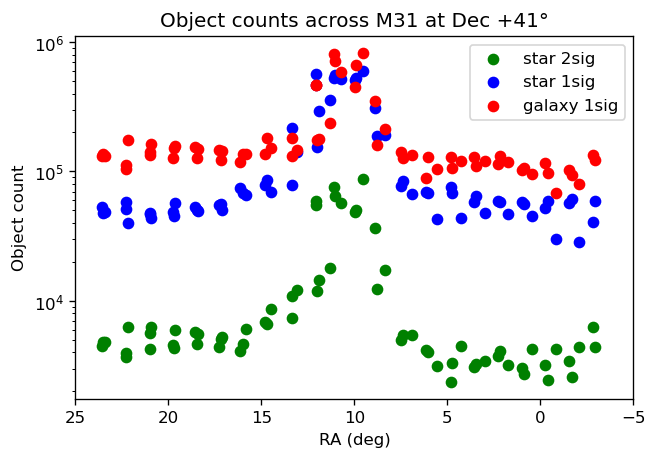

In [22]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
fig.set_dpi(120)

ax1.set_yscale('log')

ax1.scatter([field_mean_pos[f][0] for f in field_mean_pos], count_star2, c='g', label='star 2sig')
ax1.scatter([field_mean_pos[f][0] for f in field_mean_pos], count_star1, c='b', label='star 1sig')
ax1.scatter([field_mean_pos[f][0] for f in field_mean_pos], count_gal1, c='r', label='galaxy 1sig')
plt.legend(loc='upper right')
plt.xlabel('RA (deg)')
plt.ylabel('Object count')
plt.title('Object counts across M31 at Dec +41°')
plt.xlim(-5,25)
plt.gca().invert_xaxis()

## Colour
Calculate average colour of each class

Colours based on ii **and** ig guesses

In [12]:
colours = {}
#calculate mean g-i colour of each field
for n in CAT:
    col_sat = np.mean(CAT[n]['g'][(CAT[n]['ig']==-9)&(CAT[n]['ii']==-9)] - CAT[n]['i'][(CAT[n]['ig']==-9)&(CAT[n]['ii']==-9)])
    col_2sigstar = np.mean(CAT[n]['g'][(CAT[n]['ig']==-2)&(CAT[n]['ii']==-2)] - CAT[n]['i'][(CAT[n]['ig']==-2)&(CAT[n]['ii']==-2)])
    col_1sigstar = np.mean(CAT[n]['g'][(CAT[n]['ig']==-1)&(CAT[n]['ii']==-1)] - CAT[n]['i'][(CAT[n]['ig']==-1)&(CAT[n]['ii']==-1)])
    col_1siggal  = np.mean(CAT[n]['g'][(CAT[n]['ig']==1)&(CAT[n]['ii']==1)] - CAT[n]['i'][(CAT[n]['ig']==1)&(CAT[n]['ii']==1)])
    col_2siggal = np.mean(CAT[n]['g'][(CAT[n]['ig']==2)&(CAT[n]['ii']==2)] - CAT[n]['i'][(CAT[n]['ig']==2)&(CAT[n]['ii']==2)])
    colours[n] = (col_sat,col_2sigstar,col_1sigstar,col_1siggal, col_2siggal)

C:\Users\jwarn\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3438: RuntimeWarning: Mean of empty slice.
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
C:\Users\jwarn\anaconda3\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Colours based **only** on ig guesses

In [24]:
colours = {}
#calculate mean g-i colour of each field
for n in CAT:
    col_sat = np.mean(CAT[n]['g'][CAT[n]['ig']==-9] - CAT[n]['i'][CAT[n]['ig']==-9])
    col_2sigstar = np.mean(CAT[n]['g'][CAT[n]['ig']==-2] - CAT[n]['i'][CAT[n]['ig']==-2])
    col_1sigstar = np.mean(CAT[n]['g'][CAT[n]['ig']==-1] - CAT[n]['i'][CAT[n]['ig']==-1]) 
    col_1siggal  = np.mean(CAT[n]['g'][CAT[n]['ig']==1] - CAT[n]['i'][CAT[n]['ig']==1])
    col_2siggal = np.mean(CAT[n]['g'][CAT[n]['ig']==2] - CAT[n]['i'][CAT[n]['ig']==2])
    colours[n] = (col_sat,col_2sigstar,col_1sigstar,col_1siggal, col_2siggal)

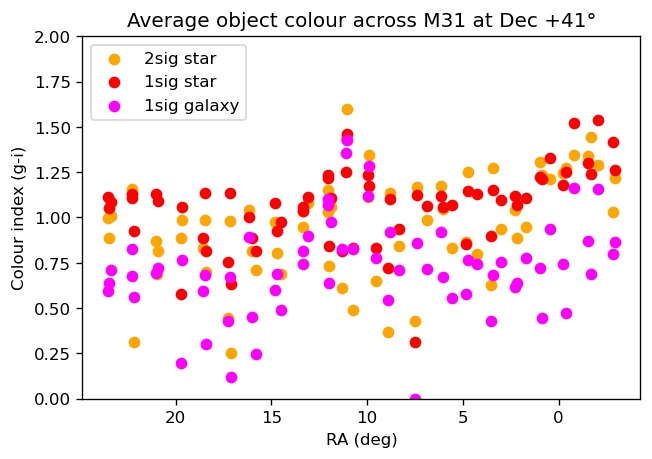

In [25]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
fig.set_dpi(120)

ax1.scatter([field_mean_pos[f][0] for f in field_mean_pos], [colours[n][1] for n in colours], c='orange', label='2sig star')
ax1.scatter([field_mean_pos[f][0] for f in field_mean_pos], [colours[n][2] for n in colours], c='red', label='1sig star')
ax1.scatter([field_mean_pos[f][0] for f in field_mean_pos], [colours[n][3] for n in colours], c='fuchsia', label='1sig galaxy')
#ax1.scatter([field_mean_pos[f][0] for f in field_mean_pos], [colours[n][4] for n in colours], c='violet', label='2sig galaxy')
#ax1.scatter([field_mean_pos[f][0] for f in field_mean_pos], [colours[n][0] for n in colours], c='lightgrey', label='saturated')

plt.legend(loc='upper left')
plt.xlabel('RA (deg)')
plt.ylabel('Colour index (g-i)')
#plt.ylim([-1,2])
plt.title('Average object colour across M31 at Dec +41°')
plt.ylim(0,2)
plt.gca().invert_xaxis()